<h2><center>Long-term Visits Prediction of 140K Web Pages</center></h2>
<font color=blue><h3><center>======= Part 4. Seq2seq Architecture with CNN ========</center></h3></font>

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Load the data downloaded from the Kaggle website
df = pd.read_csv("/Users/YingShen/Desktop/Data_Science/SpringBorad/Projects_Datasets/all/train_2.csv")
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [4]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-07-01 to 2017-09-10


In [5]:
from datetime import timedelta

pred_steps = 62
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime("2016-05-10")#data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [6]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

In [7]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2016-05-10 00:00:00 - 2017-05-09 00:00:00
Train prediction: 2017-05-10 00:00:00 - 2017-07-10 00:00:00 

Val encoding: 2016-07-11 00:00:00 - 2017-07-10 00:00:00
Val prediction: 2017-07-11 00:00:00 - 2017-09-10 00:00:00

Encoding interval: 365
Prediction interval: 62


In [55]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])
# fill the NaN values with 0 since the dataset does not distinguish between 0 and missing
df=df.fillna(0)
series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [9]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from keras.optimizers import Adam

# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':62})(x)

model = Model(history_seq, pred_seq_train)

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          2080      
__________

In [11]:
first_n_samples = 20000
batch_size = 2**11
epochs = 20

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
16000/16000 [==============================] - 168s 10ms/step - loss: 0.4248 - val_loss: 0.3491
Epoch 2/20
16000/16000 [==============================] - 170s 11ms/step - loss: 0.3381 - val_loss: 0.2949
Epoch 3/20
16000/16000 [==============================] - 143s 9ms/step - loss: 0.3056 - val_loss: 0.2543
Epoch 4/20
16000/16000 [==============================] - 142s 9ms/step - loss: 0.2870 - val_loss: 0.2343
Epoch 5/20
16000/16000 [==============================] - 208s 13ms/step - loss: 0.2785 - val_loss: 0.2261
Epoch 6/20
16000/16000 [==============================] - 169s 11ms/step - loss: 0.2736 - val_loss: 0.2221
Epoch 7/20
16000/16000 [==============================] - 147s 9ms/step - loss: 0.2710 - val_loss: 0.2217
Epoch 8/20
16000/16000 [==============================] - 149s 9ms/step - loss: 0.2695 - val_loss: 0.2207
Epoch 9/20
16000/16000 [==============================] - 176s 11ms/step - loss: 0.2684 - val_loss:

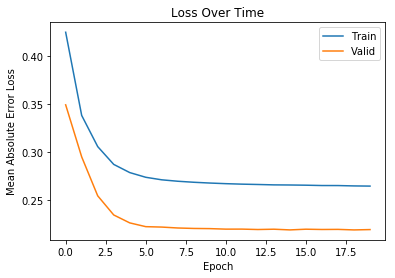

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [13]:
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model_cnn.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_cnn.h5")
print("Saved model to disk")

Saved model to disk


In [14]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

In [37]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [38]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=62):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),np.expm1(encode_series_tail))
    plt.plot(range(x_encode,x_encode+pred_steps),np.expm1(target_series),color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),np.expm1(pred_series),color='teal',linestyle='--')
    
    plt.title('CNN - Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

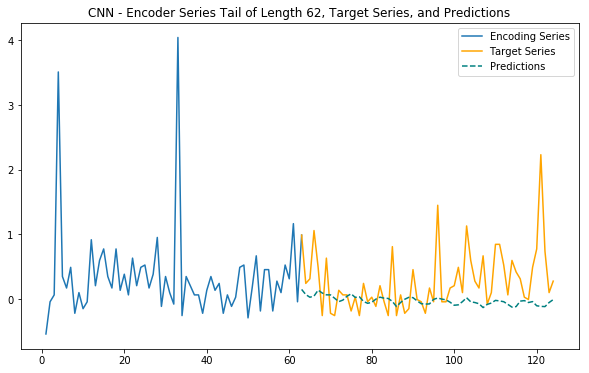

In [26]:
predict_and_plot(encoder_input_data, decoder_target_data, 227)

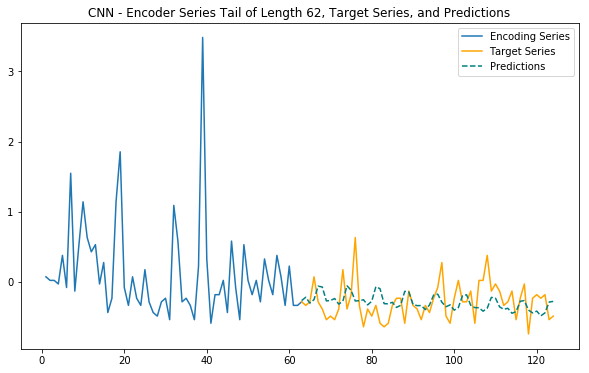

In [39]:
predict_and_plot(encoder_input_data, decoder_target_data, 2919)

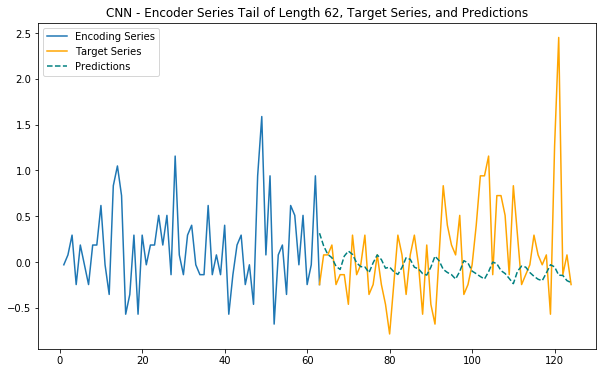

In [27]:
predict_and_plot(encoder_input_data, decoder_target_data, 3374)

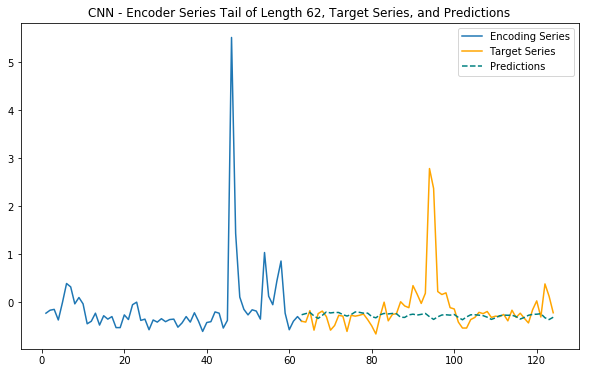

In [40]:
predict_and_plot(encoder_input_data, decoder_target_data, 8135)

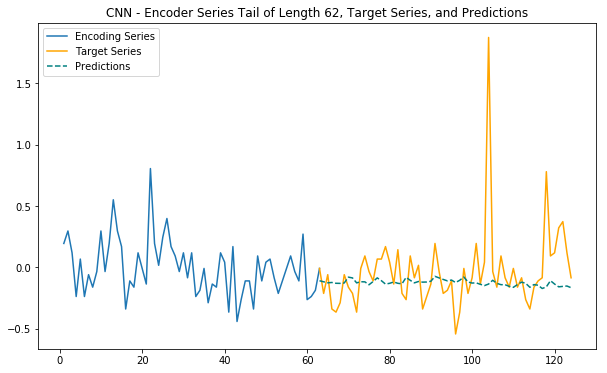

In [42]:
predict_and_plot(encoder_input_data, decoder_target_data, 109901)

In [56]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
# (145063, 679, 1), (145063, 1)

# (145063, 62)
decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)

In [57]:
def smape(true, pred):
    summ = np.abs(true+pred)
    diff = np.abs(true-pred)
    df_smape = np.where(summ == 0, 0, diff / summ)
    smape = 200*df_smape.sum()/true.shape[0]
    return smape 

In [59]:
import datetime

smape_s=0
for i in range(0,df.shape[0]):
    # Get the transformed series
    encode_series = encoder_input_data[i:i+1,:,:] 
    
    # Predict the target value with trained model
    pred_series = predict_sequence(encode_series)    
    pred_series = pred_series.reshape(-1,1) 
    
    # Back transform the prediction with mean and inverse of the np.log1p
    pred_series=pred_series+encode_series_mean[i]
    pred_series=np.expm1(pred_series)
    
    # Get the target series from the original data without transformation
    target_series = decoder_target_data[i].reshape(-1,1) 
    
    smape_i=smape(target_series,pred_series)
    smape_s=smape_s+smape_i
    if i%1000==0 or i in (5,10,50,100):
        print(i,smape_s)
        print(datetime.datetime.now())

print(smape_s/df.shape[0])

0 34.50706137175881
2018-10-29 22:09:08.910060
5 288.6923078422794
2018-10-29 22:09:09.962837
10 518.5424357283624
2018-10-29 22:09:10.990509
50 2304.176545121751
2018-10-29 22:09:19.476988
100 5330.380059792955
2018-10-29 22:09:29.648588
1000 45611.85979610805
2018-10-29 22:13:03.255675
2000 89334.58922214512
2018-10-29 22:17:04.610054
3000 133095.9630192925
2018-10-29 22:20:23.862795
4000 180141.32150849205
2018-10-29 22:23:37.231929
5000 221065.54637544058
2018-10-29 22:27:02.479521
6000 253124.50915819863
2018-10-29 22:30:15.081662
7000 285720.9901709587
2018-10-29 22:33:26.044120
8000 318620.7796395428
2018-10-29 22:36:37.172428
9000 351063.8628483469
2018-10-29 22:39:48.222920
10000 377028.6489763418
2018-10-29 22:42:59.232163
11000 405282.88283777644
2018-10-29 22:46:17.016832
12000 432774.5265949053
2018-10-29 22:49:30.356498
13000 460246.722574517
2018-10-29 22:52:49.127860
14000 535537.1481243278
2018-10-29 22:56:35.102041
15000 651026.2985360224
2018-10-29 23:00:28.699052
16